Processing Kevin.csv data
Creating RawArray with float64 data, n_channels=8, n_times=101
    Range : 0 ... 100 =      0.000 ...     0.400 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_616/1463519470.py:64: RuntimeWarning: filter_length (825) is longer than the signal (101), distortion is likely. Reduce filter length or filter a longer signal.
  raw_data.filter(l_freq=1, h_freq=50)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


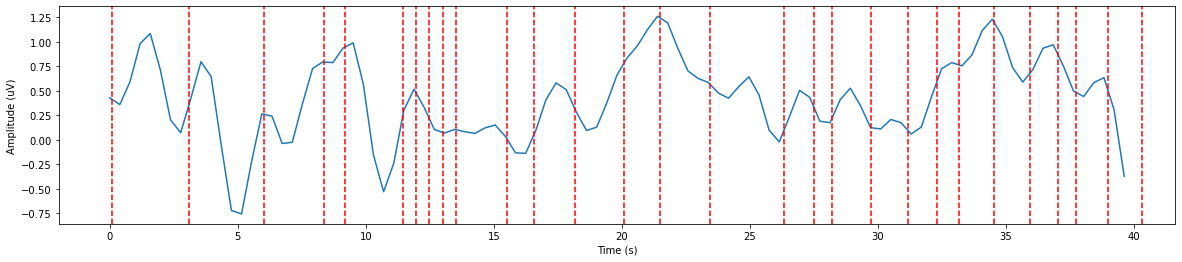

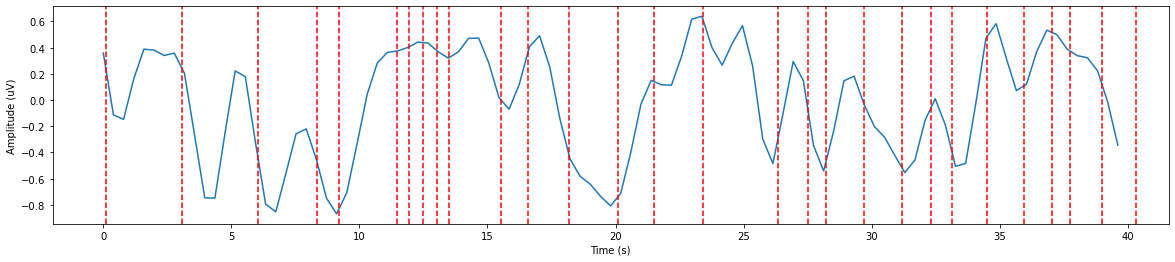

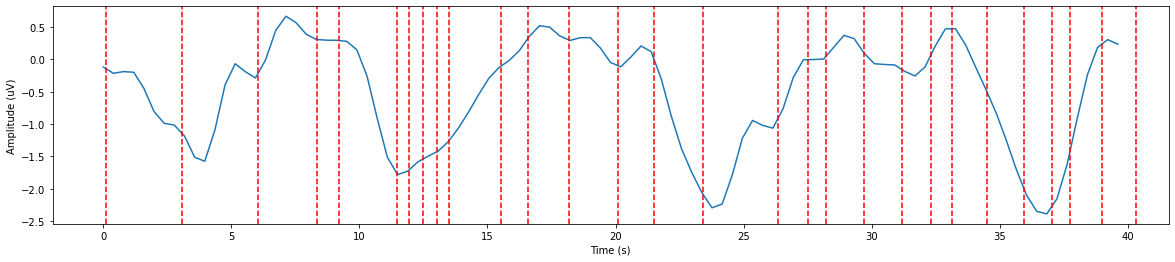

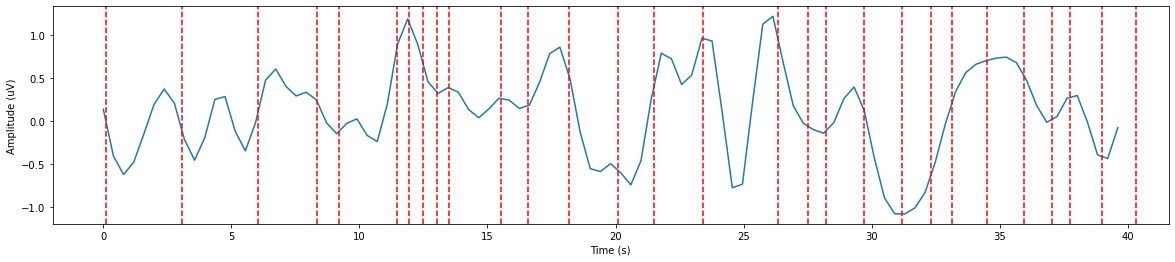

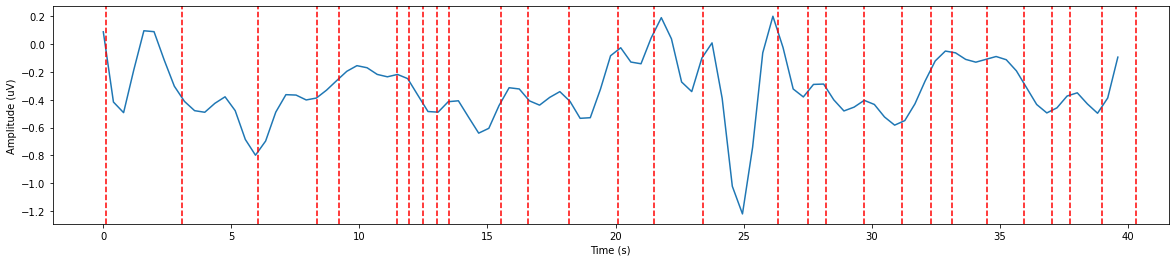

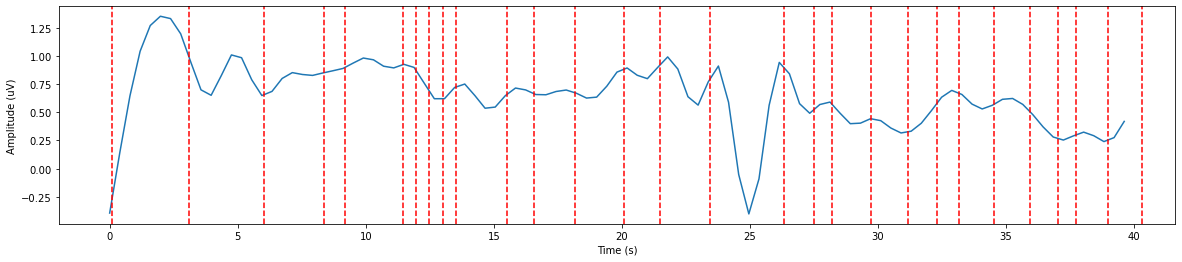

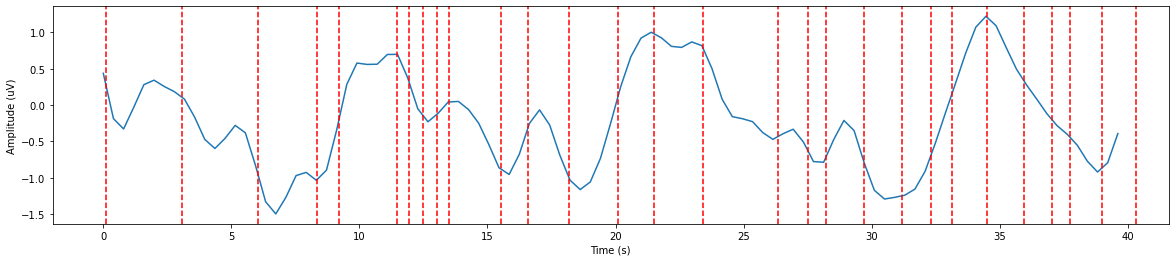

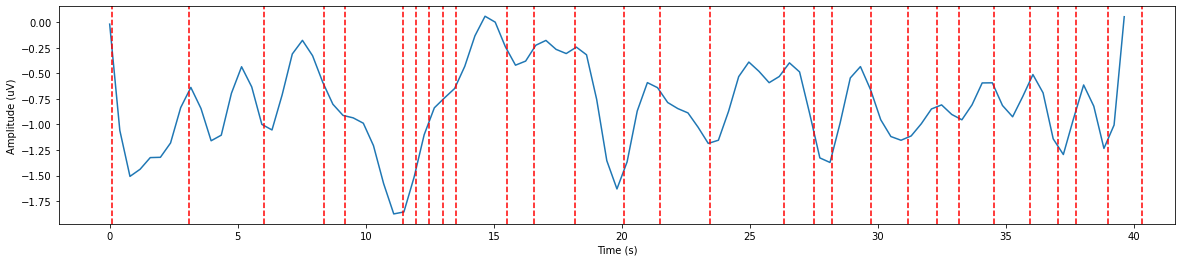

Processing Benson.csv data
Creating RawArray with float64 data, n_channels=8, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.396 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)



/tmp/ipykernel_616/1463519470.py:64: RuntimeWarning: filter_length (825) is longer than the signal (100), distortion is likely. Reduce filter length or filter a longer signal.
  raw_data.filter(l_freq=1, h_freq=50)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


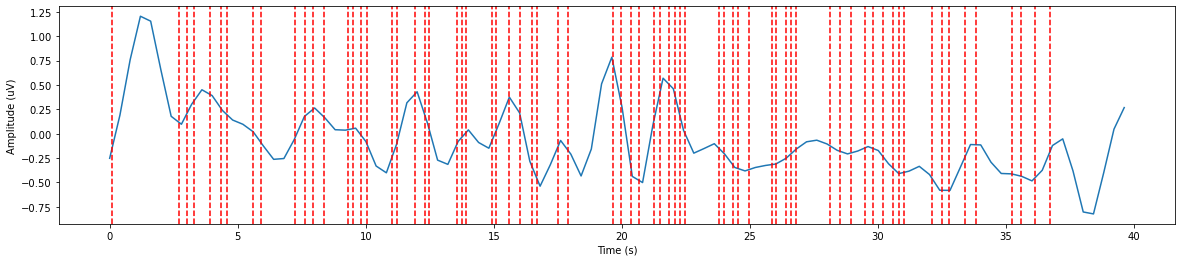

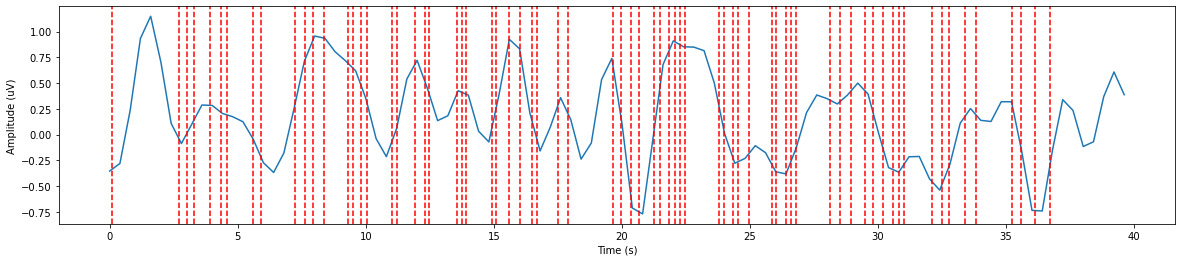

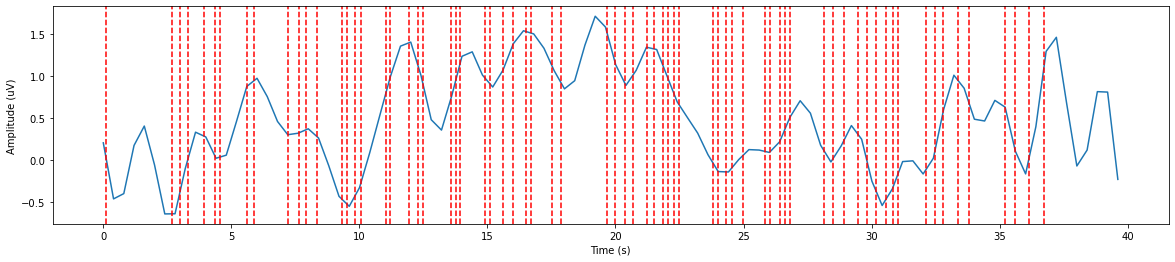

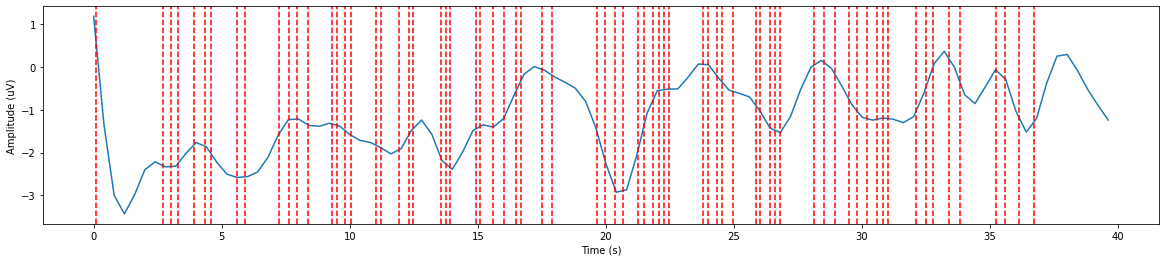

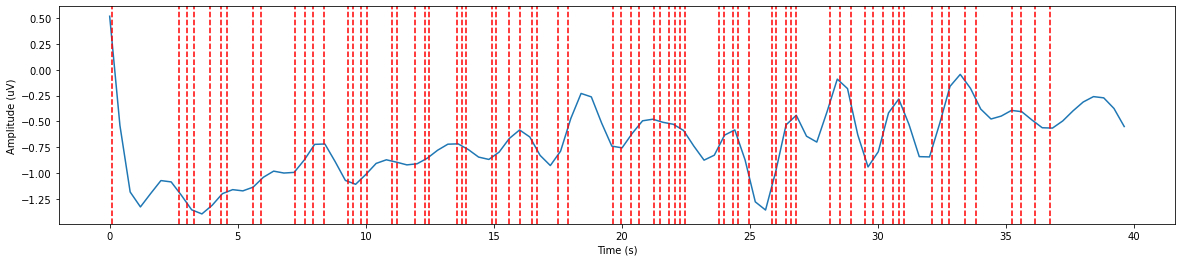

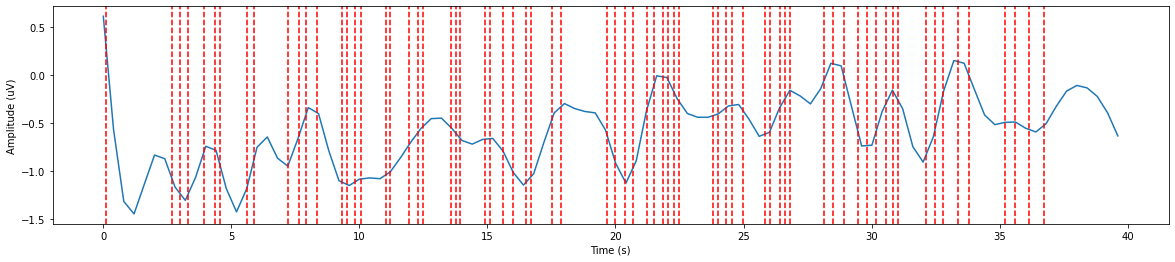

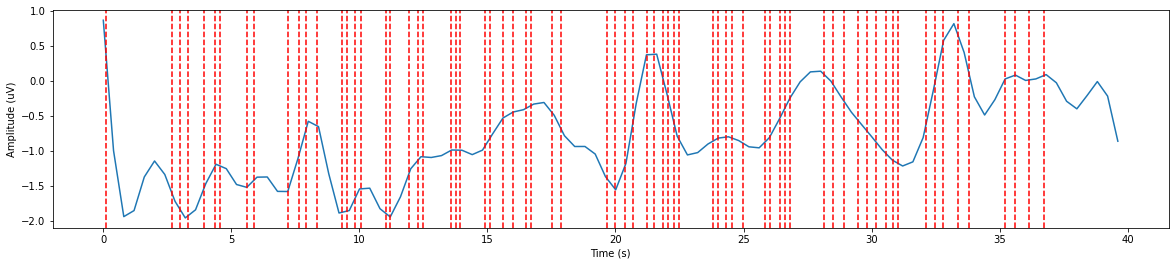

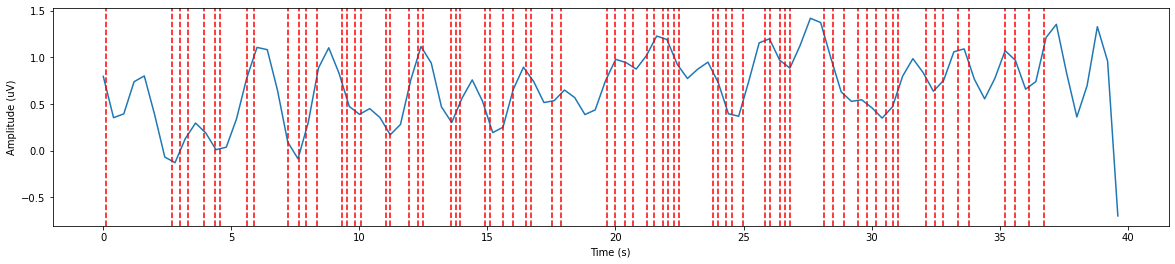

In [5]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
import re
#Code from online source to convert macro file into timestamps
def convert_mouse_clicks(macro_file):
    with open(macro_file) as f:
        lines = f.readlines()

    result = []
    for line in lines:
        if "<Delay>" in line:
            result.append(int(re.sub('\D', '', line)))

    result.insert(0, 0)
    result = [float(i) * 0.001 for i in result]
    result = [round(i, 4) if isinstance(i, float) else i for i in result]

    sum_list = []
    for i in range(0, len(result) - 1, 2):
        if isinstance(result[i], float) and isinstance(result[i + 1], float):
            sum_list.append(result[i] + result[i + 1])

    for i in range(1, len(sum_list)):
        sum_list[i] += sum_list[i - 1]
    sum_list = [round(i, 4) if isinstance(i, float) else i for i in sum_list]

    return sum_list
#function to process eeg data using pandas and mne
def eeg_data(filename, macro_file, start=500, end_time=None):
    eeg_data = pd.read_csv(filename, delimiter='\t', header=None)
    eeg_data = eeg_data.iloc[start:]
    
    #calculates the difference between timestamps to generate the time for x axis
    timestamps = eeg_data.iloc[:, 22]
    new_timestamps = timestamps - timestamps.iloc[0]
    eeg_data[22] = new_timestamps
    
    #setting the end time to only plot a segment of data
    if end_time is not None:
        max_time = eeg_data[22].iloc[0] + end_time
        eeg_data = eeg_data[eeg_data[22] <= max_time]
        new_timestamps = eeg_data[22]
        
    #select chennels from data
    selected_columns = eeg_data.iloc[:, [i for i in range(1, 9)]]
    
    #normalize the data using z-score with index of 100 to smooth the graph for better visualiability
    rolling_mean = selected_columns.rolling(window=100).mean()
    rolling_std = selected_columns.rolling(window=100).std()
    normalized_data = (selected_columns - rolling_mean) / rolling_std
    normalized_mean_data = normalized_data.groupby(normalized_data.index // 100).mean()
    
    #generate a evenly spaced time axis
    time_axis = np.linspace(0, new_timestamps.iloc[-1], len(normalized_mean_data))
    
    #since the data is self collected, the command to generate raw data using mne is most suited in this situation
    channels = ['FP1', 'FZ', 'CZ', 'PZ', 'O1', 'O2', 'C3', 'C4']
    info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
    raw_data = mne.io.RawArray(normalized_mean_data.T, info)

    #apply standard EEG filter
    raw_data.filter(l_freq=1, h_freq=50)

    mouse_clicks = convert_mouse_clicks(macro_file)
    
    #create a for loop for plots
    for i, ch_name in enumerate(channels):
        plt.figure(figsize=(20, 4))
        plt.plot(time_axis, raw_data.get_data(picks=ch_name).T, label=ch_name)
        for click_time in mouse_clicks:
            plt.axvline(x=click_time, color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (uV)')
        plt.show()
print("Processing Kevin.csv data")
eeg_data('Kevin.csv', 'kevin_macro.txt', start=500, end_time=40)

print("Processing Benson.csv data")
eeg_data('Benson.csv', 'benson_macro.txt', start=500, end_time=40)

